In [1]:
%load_ext autoreload
%autoreload 2
from robot_arms import *
import numpy as np
import jacobian
import matplotlib.pyplot as plt
from matplotlib import patches
import trajectory_planning
import angular_velocity_for_movement
import forward_kinematics
import circle
import fractions

## Problem 5

In [17]:
etas = np.array(((0,    0,      0, 0),
                 (0,     -0.027, 0, 0),
                 (0,    0,      -0.027, 0),
                 (0,    0.027,  0, 0),
                 (0,    0,      0, 0)))
for eta in etas:
    phi = np.pi/2
    angles = circle.get_angles_for_phi(phi)
    angle_velocities = jacobian.transform(angles, eta)
    print(angle_velocities)

[0. 0. 0. 0.]
[-1.80000000e-01  3.83578570e-18 -4.14528005e-18  3.09494350e-19]
[-1.38666956e-34  2.95124864e-02 -3.23678962e-01  2.94166476e-01]
[ 1.80000000e-01 -3.83578570e-18  4.14528005e-18 -3.09494350e-19]
[0. 0. 0. 0.]


In [13]:
0.18 * 0.15

0.027

In [3]:
N = 100
get_phis = lambda n:np.array([2*i*np.pi/(n-1) for i in range(n)])
ticks = np.arange(0, 2.1, 0.5)
pi_string = "$\pi$"
labels = [F'{fractions.Fraction(tick) if tick != 1 else ""}{pi_string if tick != 0 else ""}' for tick in ticks]


In [4]:
lin_velocities = np.array(((0,0,0), (0,-0.027, 0), (0,0,-0.027), (0,0.027,0), (0,0,0)))
matricies = trajectory_planning.circle_path(n_knots = 5, lin_velocities=lin_velocities)

In [5]:
k = []
for matrix in matricies:
    for i in np.linspace(0, 2, 50):
        angles = matrix @ trajectory_planning.position_t_array(i)
        t = forward_kinematics.T04(*angles)
        k.append((t[1,3], t[2, 3]))
k = np.array(k)

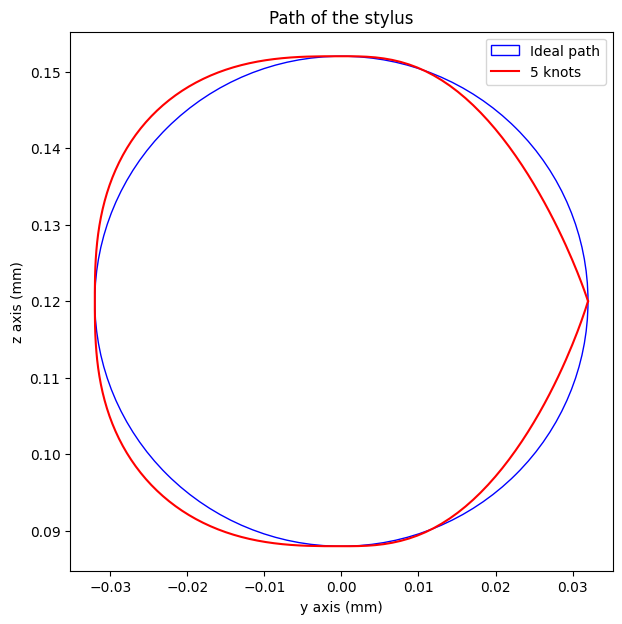

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(7,7)
ax.set_title("Path of the stylus")
circle2 = patches.Circle((0, 0.120), 0.032, color='b', fill=False)
ax.add_patch(circle2)
# ax.set_xlim((-0.040, 0.040))
# ax.set_ylim((0.080, 0.160))
ax.set_xlabel('y axis (mm)')
ax.set_ylabel('z axis (mm)')
ax.plot(k[:,0], k[:,1], color = 'r')
# ax.plot(k[:,0], k[:,1], color = 'r')

ax.legend(('Ideal path','5 knots'))

# fig.savefig("circle.png")
plt.show()

In [7]:
np.sqrt(48.89**2 + 10.432**2)

np.float64(49.99058635383266)

## Plot condition number


Text(0.5, 1.0, 'Condition number of jacobian as a function of $\\varphi$')

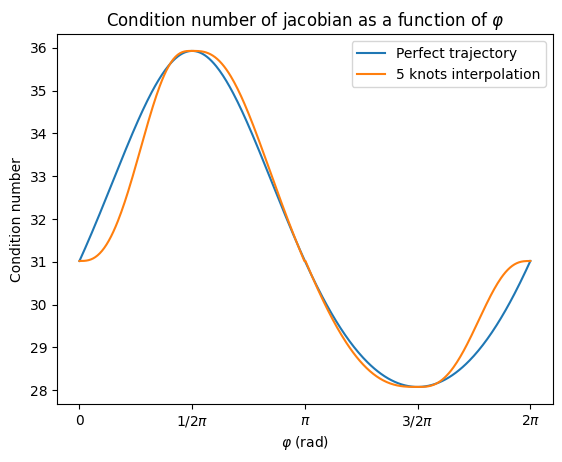

In [8]:
phis = get_phis(len(matricies)*N)
true_path_conds = []
for phi in phis:
    angles = circle.get_angles_for_phi(phi)
    j = jacobian.jacobian(*angles)
    
    true_path_conds.append(np.linalg.cond(j))

conds = []
for matrix in matricies:
    for i in np.linspace(0, 2, N):
        angles = matrix @ trajectory_planning.position_t_array(i)
        angles[np.abs(angles) < 1e-10] = 0
        j = jacobian.jacobian(*angles)
        conds.append(np.linalg.cond(j))

fig, ax = plt.subplots(1,1)
ax.plot(phis/np.pi, true_path_conds)
ax.plot(phis/np.pi,conds)
ax.set_xticks(labels = labels, ticks = ticks)
ax.set_xlabel(r'$\varphi$ (rad)')
ax.set_ylabel('Condition number')
ax.legend(('Perfect trajectory', '5 knots interpolation'))
ax.set_title(r'Condition number of jacobian as a function of $\varphi$')

## Torques

In [9]:

N= 100
torques = np.empty((N, 4))
def get_r(t):
    return np.sqrt(t[0,3]**2 + t[1,3]**2)

phis = []
for i in range(N):
    phi = 2*np.pi*i/N
    phis.append(phi/np.pi)
    q1,q2,q3,q4 = circle.get_angles_for_phi(phi)
    T01 = forward_kinematics.T01(q1)
    T12 = forward_kinematics.T12(q2)
    T23 = forward_kinematics.T23(q3)
    T34 = forward_kinematics.T34(q4)
    
    t = [0]
    T04 = forward_kinematics.T04(q1, q2, q3, q4)
    # print(T04)
    t.append(get_r(T04))
    t.append(get_r(T04-T01@T12))
    t.append(get_r(T04-T01@T12@T23))
    # print(t)
    torques[i] = t
    


Text(0.5, 1.0, 'Torques in the joints as functions of $\\varphi$ when following a circular path')

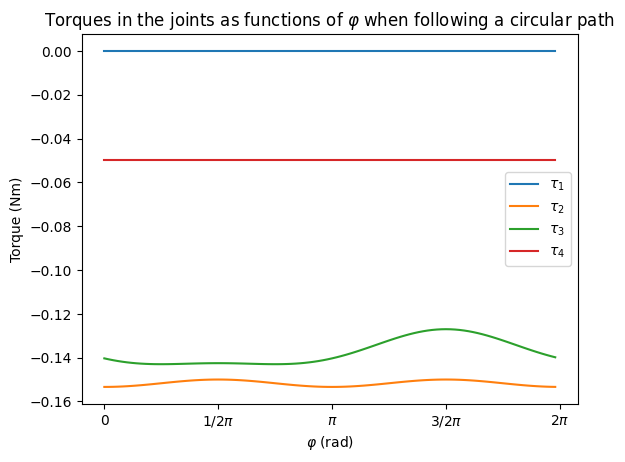

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(phis, -torques)
ax.set_xticks(labels = labels, ticks = ticks)
ax.legend(('$\\tau_1$', '$\\tau_2$', '$\\tau_3$', '$\\tau_4$'))
ax.set_ylabel('Torque (Nm)')
ax.set_xlabel(r'$\varphi$ (rad)')
ax.set_title(r'Torques in the joints as functions of $\varphi$ when following a circular path')
#TODO make sure y axis is really in Nm